In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
from dateutil.relativedelta import relativedelta
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import re
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df = pd.read_csv('data/f700.csv', encoding = 'latin1')
df.head()

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,pub_rec_bankruptcies,issue_d,earliest_cr_line
0,1,5000,36 months,Fully Paid,10.65%,10+ years,RENT,24000.0,Verified,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,1,NaN,NaN,3,0,9,0.0,Dec-11,Jan-85
1,2,2500,60 months,Charged Off,15.27%,< 1 year,RENT,30000.0,Source Verified,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,5,NaN,NaN,3,0,4,0.0,Dec-11,Apr-99
2,3,2400,36 months,Fully Paid,15.96%,10+ years,RENT,12252.0,Not Verified,NaN,small_business,real estate business,606xx,IL,8.72,0,2,NaN,NaN,2,0,10,0.0,Dec-11,Nov-01
3,4,10000,36 months,Fully Paid,13.49%,10+ years,RENT,49200.0,Source Verified,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,1,35.0,NaN,10,0,37,0.0,Dec-11,Feb-96
4,5,3000,60 months,Fully Paid,12.69%,1 year,RENT,80000.0,Source Verified,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0,0,38.0,NaN,15,0,38,0.0,Dec-11,Jan-96


In [3]:
df.isnull().sum()

member_id                     0
loan_amnt                     0
term                          0
loan_status                   0
int_rate                      0
emp_length                 1078
home_ownership                0
annual_inc                    0
verification_status           0
desc                      12967
purpose                       0
title                        11
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
mths_since_last_delinq    25727
mths_since_last_record    36994
open_acc                      0
pub_rec                       0
total_acc                     0
pub_rec_bankruptcies        697
issue_d                       0
earliest_cr_line              0
dtype: int64

In [4]:
df.term = df.term.str.replace('months', '').astype('float') #处理term变量中的数据 改为连续值
df['bad_id'] = df.loan_status.apply(lambda x: int(x == 'Charged Off')) #将loan_status转换为我们的y值
df['int_rate'] = df.int_rate.apply(lambda x: float(x.replace('%', ''))/100) #将利率数据数值化
df.desc = df.desc.apply(lambda x : 0 if str(x) == 'nan' else 1) # 将文字型变量简单根据是否空缺分为0，1值

In [5]:
def year_clean(x):
    if x == '< 1 year':
        return 0
    elif x == '10+ years':
        return 11
    elif str(x) == 'nan':
        return 1
    else:
        return int(re.sub(r'\D+', '', x))
    
df.emp_length = df.emp_length.apply(lambda x: year_clean(x)) # 用正则表达式 对year类数据进行清理

In [6]:
dt.datetime(2017,3,1)

datetime.datetime(2017, 3, 1, 0, 0)

In [7]:
def time_clean(x):
    if str(x) == 'nan':
        return dt.datetime(1900,1,1)
    map1 = {
        'Jan': 1,
        'Feb': 2,
        'Mar': 3,
        'Apr': 4,
        'May': 5,
        'Jun': 6,
        'Jul': 7,
        'Aug': 8,
        'Sep': 9,
        'Oct': 10,
        'Nov': 11,
        'Dec': 12
    }
    m = map1[x[:3]]
    y = int(x[-2:])
    if y >= 20:
        y = y + 1900
    else:
        y = y+2000
    return dt.datetime(y,m,1)
df.issue_d = df.issue_d.apply(lambda x : time_clean(x))
df.earliest_cr_line = df.earliest_cr_line.apply(lambda x: time_clean(x)) #清理时间数据 将起转换为dt格式

In [8]:
df.isnull().sum()

member_id                     0
loan_amnt                     0
term                          0
loan_status                   0
int_rate                      0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
desc                          0
purpose                       0
title                        11
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
mths_since_last_delinq    25727
mths_since_last_record    36994
open_acc                      0
pub_rec                       0
total_acc                     0
pub_rec_bankruptcies        697
issue_d                       0
earliest_cr_line              0
bad_id                        0
dtype: int64

In [9]:
df.dropna(subset = ['title'], axis = 0, inplace=True)# 因为title变量的缺失值较少 我们直接采用删除的策略
df.fillna(-1, inplace=True) #其他缺失值较多的 我们用-1 代替

In [10]:
# 变量衍生 这里 我们采用 收入负债占比 和时间差两个做衍生
df['debt_income_rate'] = round(df['loan_amnt'] / df['annual_inc'],2)
def time_period(x,y):
    if x > y:
        gap = relativedelta(x, y)
        m = gap.months
        y = gap.years
        return y*12 + m
    else:
        return 0
    
df['time_gap'] = df.apply(lambda x: time_period(x.issue_d, x.earliest_cr_line), axis=1)
df = df[df.term == 36]   # 因为不同时间数据集差距较大 为了模型的准确性 我们用同一时间的数据集进行建模  

In [11]:
df.head()

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,pub_rec_bankruptcies,issue_d,earliest_cr_line,bad_id,debt_income_rate,time_gap
0,1,5000,36.0,Fully Paid,0.1065,11,RENT,24000.0,Verified,1,credit_card,Computer,860xx,AZ,27.65,0,1,-1.0,-1.0,3,0,9,0.0,2011-12-01,1985-01-01,0,0.21,323
2,3,2400,36.0,Fully Paid,0.1596,11,RENT,12252.0,Not Verified,0,small_business,real estate business,606xx,IL,8.72,0,2,-1.0,-1.0,2,0,10,0.0,2011-12-01,2001-11-01,0,0.20,121
3,4,10000,36.0,Fully Paid,0.1349,11,RENT,49200.0,Source Verified,1,other,personel,917xx,CA,20.00,0,1,35.0,-1.0,10,0,37,0.0,2011-12-01,1996-02-01,0,0.20,190
5,6,5000,36.0,Fully Paid,0.0790,3,RENT,36000.0,Source Verified,0,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0,3,-1.0,-1.0,9,0,12,0.0,2011-12-01,2004-11-01,0,0.14,85
7,8,3000,36.0,Fully Paid,0.1864,9,RENT,48000.0,Source Verified,1,car,Car Downpayment,900xx,CA,5.35,0,2,-1.0,-1.0,4,0,4,0.0,2011-12-01,2007-01-01,0,0.06,59


In [12]:
df2 = df.copy() #数据集分为 训练集和测试集
num_features = [
    'loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'desc', 'dti',
    'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
    'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
    'pub_rec_bankruptcies', 'debt_income_rate', 'time_gap'
]
dis_features = ['home_ownership', 'verification_status', 'purpose', 'zip_code', 'addr_state'] #将不同的变量分为数值类 和离散类

In [13]:
V = DictVectorizer(sparse=False)
x1 = V.fit_transform(df2[dis_features].to_dict('record')) # 这里我们采用热编码的形式对离散型变量进行处理 转为数值型 然后放入一起做训练
x2 = df2[num_features].as_matrix()
X3 = np.hstack([x1,x2])
x_train, x_test, y_train, y_test  = train_test_split(X3, df2['bad_id'],test_size = 0.3, random_state = 0)

In [14]:
model1 = lgb.LGBMClassifier(random_state = 0) # 这里我们简单定义下 一般常用参数，后面会做进一步的调参
column = ['x' + str(y) for y in range(1, 901)]
x_train = pd.DataFrame(x_train, columns = column)
x_test = pd.DataFrame(x_test, columns = column)

In [17]:
model1.fit(x_train, y_train)
feature = pd.DataFrame({
    'feature': model1.booster_.feature_name(),
    'importance': model1.feature_importances_
}).sort_values(
    by='importance', ascending=False)
features = feature.loc[feature.importance >= 10, 'feature'].to_list() # 这里做一个变量筛选，我们将根据模型重要度>10的变量提取出来

In [18]:
x_train = x_train[features]
x_test = x_test[features]

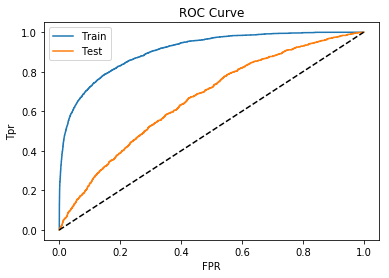

(0.6384720061454183,
 0.2418808704349213,
 array([0.09207887, 0.14338334, 0.15076731, ..., 0.04533792, 0.13544863,
        0.09957524]))

In [20]:
def ks_plot(x1,y1,x2,y2, model):
    model.fit(x1,y1)
    predict_1 = model.predict_proba(x1)[:, 1]
    predict_2 = model.predict_proba(x2)[:, 1]
    fpr1, tpr1, _= roc_curve(y1, predict_1)
    fpr2, tpr2, _= roc_curve(y2, predict_2)
    ks_train = abs(fpr1 - tpr1).max()
    ks_test = abs(fpr2 - tpr2).max()
    plt.plot(fpr1, tpr1, label = 'Train')
    plt.plot(fpr2, tpr2, label = 'Test')
    plt.plot([0,1], [0,1], 'k--')
    plt.legend(loc='best')
    plt.xlabel('FPR')
    plt.ylabel('Tpr')
    plt.title('ROC Curve')
    plt.show()
    return ks_train, ks_test,predict_2
ks_plot(x_train, y_train, x_test, y_test, model1)

In [21]:
# 开始调参
# 1. 确定最大迭代次数 即n_estimator
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'nthread': 4,
    'learning_rate': 0.1,
    'num_leaves': 30,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}
data_train = lgb.Dataset(x_train, y_train)
cv_results = lgb.cv(
    params,
    data_train,
    num_boost_round=1000,
    nfold=5,
    stratified=False,
    shuffle=True,
    metrics='auc',
    early_stopping_rounds=50,
    seed=0)
print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', pd.Series(cv_results['auc-mean']).max())

best n_estimators: 57
best cv score: 0.6743147674514793


In [22]:
#第二步 确定max_depth 和num_leaves
param_test1 = {'max_depth': range(3, 8, 1), 'num_leaves': range(5, 100, 5)}
grid1 = GridSearchCV(
    estimator=lgb.LGBMClassifier(
        boosting_type='gbdt',
        objective='binary',
        matrics='auc',
        learning_rate=0.1,
        n_estimators=44,
        max_depth=6),
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        param_grid=param_test1)

grid1.fit(x_train, y_train)

grid1.best_estimator_, grid1.best_params_, grid1.best_score_

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, matrics='auc',
                max_depth=5, min_child_samples=20, min_child_weight=0.001,
                min_split_gain=0.0, n_estimators=44, n_jobs=-1, num_leaves=15,
                objective='binary', random_state=None, reg_alpha=0.0,
                reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
 {'max_depth': 5, 'num_leaves': 15},
 0.6797498913780683)

In [23]:
# 第三步 确定min_data_in_leaf 和max_bin 
param_test2 = {'min_data_in': range(5,256,10), 'min_data_in_leaf': range(1,102,10)}
grid2 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting = 'gbdt', objective = 'binary', matrics = 'auc', learning_rate =0.1, n_estimators = 44, max_depth = 5, num_leaves = 10),param_grid = param_test2, scoring = 'roc_auc', cv = 5, n_jobs = -1)

grid2.fit(x_train, y_train)
grid2.best_estimator_, grid2.best_params_, grid2.best_score_

(LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
                colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
                matrics='auc', max_depth=5, min_child_samples=20,
                min_child_weight=0.001, min_data_in=5, min_data_in_leaf=61,
                min_split_gain=0.0, n_estimators=44, n_jobs=-1, num_leaves=10,
                objective='binary', random_state=None, reg_alpha=0.0,
                reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
 {'min_data_in': 5, 'min_data_in_leaf': 61},
 0.6810960907836431)

In [24]:
# 第四步 确定feature_fraction bagging_fraction, bagging_freq
param_test3 = {
    'feature_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
    'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
    'bagging_freq': range(0, 81, 10)
}
grid3 = GridSearchCV(
    estimator=lgb.LGBMClassifier(
        boosting='gbdt',
        objective='binary',
        matrics='auc',
        learning_rate=0.1,
        n_estimators=44,
        max_depth=5,
        num_leaves=10,
        min_data_in=5,
        min_data_in_leaf=21),
    param_grid=param_test3,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1)
grid3.fit(x_train, y_train)
grid3.best_estimator_, grid3.best_params_, grid3.best_score_

(LGBMClassifier(bagging_fraction=0.6, bagging_freq=0, boosting='gbdt',
                boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                feature_fraction=0.6, importance_type='split', learning_rate=0.1,
                matrics='auc', max_depth=5, min_child_samples=20,
                min_child_weight=0.001, min_data_in=5, min_data_in_leaf=21,
                min_split_gain=0.0, n_estimators=44, n_jobs=-1, num_leaves=10,
                objective='binary', random_state=None, reg_alpha=0.0,
                reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
 {'bagging_fraction': 0.6, 'bagging_freq': 0, 'feature_fraction': 0.6},
 0.6810120650231197)

In [25]:
# 第五步 确定lambda_l1 和lambda_l2
params_test4 = {
    'lambda_l1': [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'lambda_l2': [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

grid4 = GridSearchCV(
    estimator=lgb.LGBMClassifier(
        booting='gbdt',
        objective='binary',
        matrics='auc',
        learning_rate=0.1,
        n_estimators=44,
        max_depth=5,
        num_leaves=10,
        min_data_in=5,
        min_data_in_leaf=21,
        bagging_fraction=0.8,
        bagging_freq=10,
        feature_fraction=0.7),
    param_grid=params_test4,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1)
grid4.fit(x_train, y_train)
grid4.best_estimator_, grid4.best_params_, grid4.best_score_

(LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting_type='gbdt',
                booting='gbdt', class_weight=None, colsample_bytree=1.0,
                feature_fraction=0.7, importance_type='split', lambda_l1=1.0,
                lambda_l2=0.7, learning_rate=0.1, matrics='auc', max_depth=5,
                min_child_samples=20, min_child_weight=0.001, min_data_in=5,
                min_data_in_leaf=21, min_split_gain=0.0, n_estimators=44,
                n_jobs=-1, num_leaves=10, objective='binary', random_state=None,
                reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
 {'lambda_l1': 1.0, 'lambda_l2': 0.7},
 0.6800021237308369)

In [26]:
# 第六步 确定min_split_gain
param_test5 = {'min_split_gain':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
grid5 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type = 'gbdt', objective= 'binary', matics = 'auc', learning_rate = 0.1, n_estimators = 44, max_depth = 5, num_leaves = 10, min_data_in_leaf = 21, bagging_fraction = 0.8, bagging_freq = 10, feature_fraction = 0.7, lambda_l1 = 0.1, lambda_l2 = 0.1), param_grid = param_test5, scoring='roc_auc', cv = 5, n_jobs = -1)
grid5.fit(x_train, y_train)
grid5.best_estimator_, grid5.best_params_, grid5.best_score_

(LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
                importance_type='split', lambda_l1=0.1, lambda_l2=0.1,
                learning_rate=0.1, matics='auc', max_depth=5,
                min_child_samples=20, min_child_weight=0.001,
                min_data_in_leaf=21, min_split_gain=0.6, n_estimators=44,
                n_jobs=-1, num_leaves=10, objective='binary', random_state=None,
                reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
 {'min_split_gain': 0.6},
 0.6773909779994998)

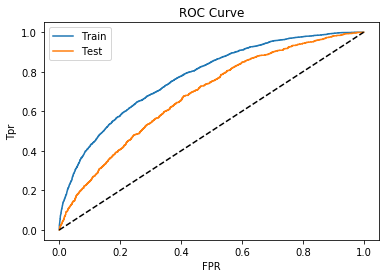

In [28]:
#降低学习率 增加迭代次数 在验证集上检验
model2 = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    matrics='auc',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=10,
    min_data_in_leaf=21,
    bagging_fraction=0.8,
    bagging_freq=10,
    feature_ftaction=0.7,
    lambda_l1=0.1,
    lambda_l2=0.1,
    min_split_gain=0.1)
ks_train, ks_test, prediction = ks_plot(x_train, y_train, x_test, y_test, model2)

In [30]:
ks_train, ks_test

(0.3924898303802478, 0.26848753115479157)

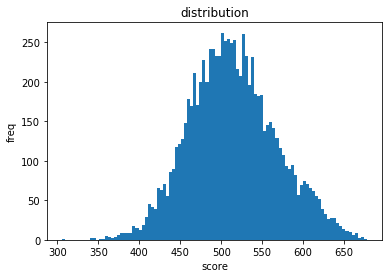

In [31]:
# 最后一步 评分
def score(p):
    score = 350 + 50 *(np.log2((1-p)/p))
    return score
x_test['score'] = score(prediction)
plt.hist(x_test['score'], 100)
plt.xlabel('score')
plt.ylabel('freq')
plt.title('distribution')
plt.show()
    